# Classificação de Imagens com Visualização

Este notebook permite classificar imagens de um diretório, mostrando cada imagem junto da predição (classe) e grau de certeza (probabilidade/confiança).

In [1]:
import os
import sys
import glob
import torch
import random
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

sys.path.append('../scripts')
from models import CorujaResNet, transforms_map
from torchinfo import summary

%matplotlib inline

In [2]:
# Caminho para o diretório de imagens
IMG_DIR = '../data/imagens_para_avaliacao'

# Obter lista de caminhos das imagens no diretório
img_paths = sorted(glob.glob(os.path.join(IMG_DIR, '*.jpg')))
print(f"Encontradas {len(img_paths)} imagens em '{IMG_DIR}'.")

img_paths

Encontradas 5 imagens em '../data/imagens_para_avaliacao'.


['../data/imagens_para_avaliacao/gato.jpg',
 '../data/imagens_para_avaliacao/humano.jpg',
 '../data/imagens_para_avaliacao/humano_distante.jpg',
 '../data/imagens_para_avaliacao/multiplos_humanos.jpg',
 '../data/imagens_para_avaliacao/paisagem.jpg']

In [3]:
# Caminho do modelo e dispositivo
MODEL_PATH = '../models/grandao.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar modelo
def carregar_modelo(model_path, device):
    ext = os.path.splitext(model_path)[1]
    if ext == '.pth':
        model = CorujaResNet()
        model.load_state_dict(torch.load(model_path, map_location=device))
    elif ext == '.pt':
        model = torch.load(model_path, map_location=device)
    else:
        raise ValueError(f"Extensão de modelo não suportada: {ext}")
    model.to(device)
    model.eval()
    return model

# Transformação padrão
transform = transforms_map["val"]

model = carregar_modelo(MODEL_PATH, DEVICE)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
CorujaResNet                                  [1, 1]                    --
├─ResNet: 1-1                                 [1, 1]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]      

In [4]:
def classificar_e_visualizar_dir(img_dir:str, model:CorujaResNet):
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
    print(f"Classificando {len(img_files)} imagens em '{img_dir}'...")
    for img_file in tqdm(img_files, desc="Classificando", leave=True):
        img = Image.open(img_file).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
            pred = 1 if prob > 0.5 else 0
        classe = 'Classe 1' if pred == 1 else 'Classe 0'
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"{os.path.basename(img_file)}\nPredição: {classe} | Certeza: {prob:.2%}", fontsize=14)
        plt.axis('off')
        plt.show()

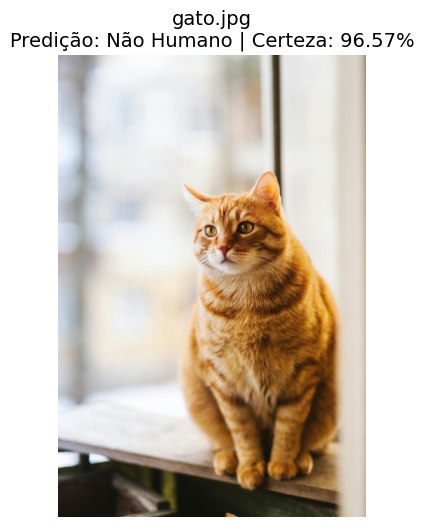

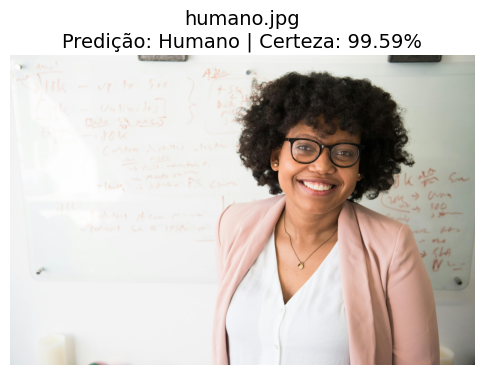

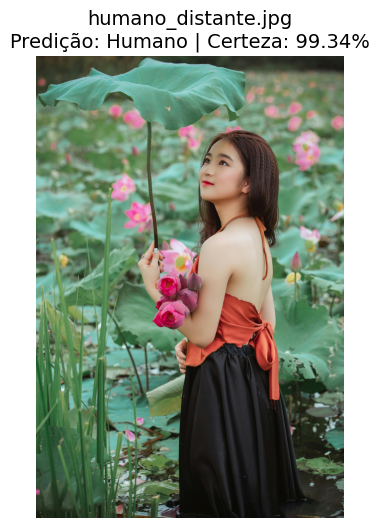

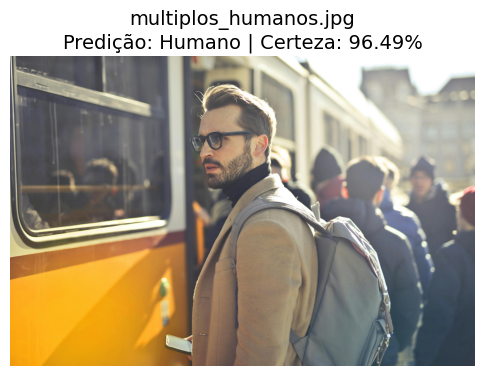

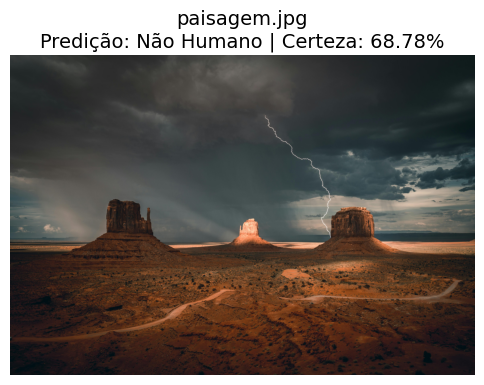

In [5]:
for img_path in img_paths:
    # Abrir a imagem e aplicar as transformações
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)
    
    # Fazer a classificação
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0
    
    # Exibir os resultados
    classe = 'Não Humano' if pred == 1 else 'Humano'
    certeza = prob if pred == 1 else 1 - prob
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"{os.path.basename(img_path)}\nPredição: {classe} | Certeza: {certeza:.2%}", fontsize=14)
    plt.axis('off')
    plt.show()

In [6]:
def modificar_e_classificar(img_path, model, transform, device):
    img = Image.open(img_path).convert('RGB')
    img_np = np.array(img)
    h, w, c = img_np.shape
    modificacoes = [
        ('Original', img),
        ('Baixa resolução', img.resize((64, 64)).resize((224, 224))),
        ('Preto e branco', img.convert('L').convert('RGB')),
        ('Blur', img.filter(ImageFilter.GaussianBlur(radius=5))),
        ('Ruído', Image.fromarray((img_np + np.random.normal(0, 40, img_np.shape)).clip(0,255).astype(np.uint8))),
        ('Rotação', img.rotate(random.randint(20, 340)))
    ]
    for nome, img_mod in modificacoes:
        input_tensor = transform(img_mod).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
            pred = 1 if prob > 0.5 else 0
        classe = 'Não Humano' if pred == 1 else 'Humano'
        certeza = prob if pred == 1 else 1 - prob
        plt.figure(figsize=(5, 5))
        plt.imshow(img_mod)
        plt.title(f"{nome}\nPredição: {classe} | Certeza: {certeza:.2%}", fontsize=12)
        plt.axis('off')
        plt.show()
    # Combina todas as distorções
    img_comb = img.resize((64, 64)).resize((224, 224))
    img_comb = img_comb.convert('L').convert('RGB')
    img_comb = img_comb.filter(ImageFilter.GaussianBlur(radius=5))
    img_comb_np = np.array(img_comb)
    img_comb_np = (img_comb_np + np.random.normal(0, 40, img_comb_np.shape)).clip(0,255).astype(np.uint8)
    img_comb = Image.fromarray(img_comb_np)
    img_comb = img_comb.rotate(random.randint(20, 340))
    input_tensor = transform(img_comb).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0
    classe = 'Não Humano' if pred == 1 else 'Humano'
    certeza = prob if pred == 1 else 1 - prob
    plt.figure(figsize=(5, 5))
    plt.imshow(img_comb)
    plt.title(f"Todas as distorções\nPredição: {classe} | Certeza: {certeza:.2%}", fontsize=12)
    plt.axis('off')
    plt.show()

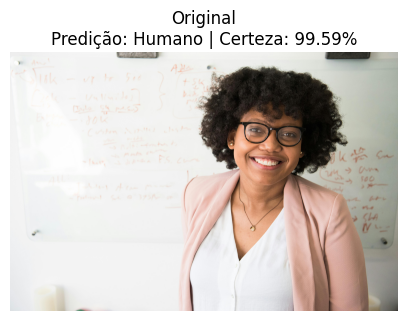

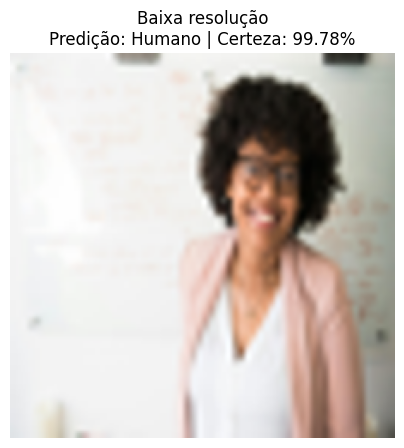

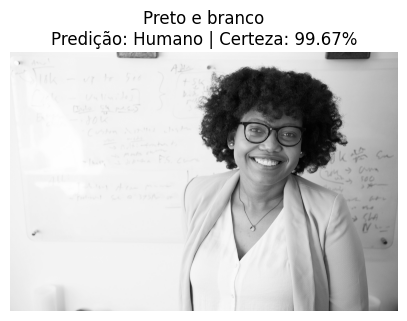

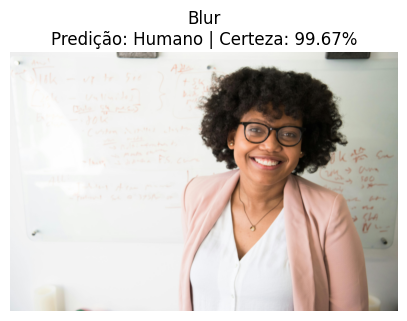

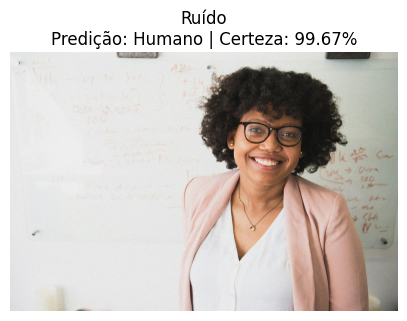

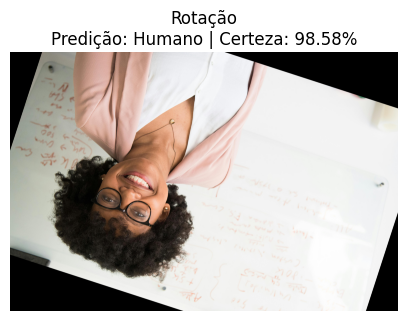

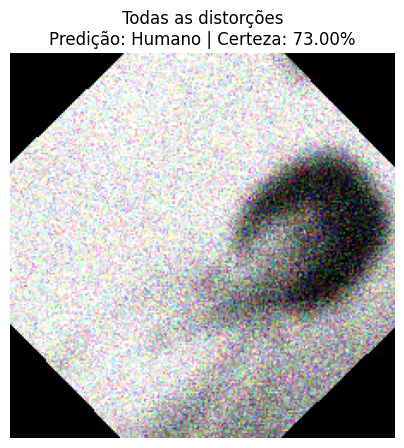

In [7]:
modificar_e_classificar(img_paths[1], model, transform, DEVICE)